In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import os
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from dython.nominal import associations, numerical_encoding, cluster_correlations
from dython.data_utils import split_hist

from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go


In [316]:
sns.set_theme(style='whitegrid', palette='pastel')

In [317]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv"
data = pd.read_csv(url)
df = data.copy()

# make sure it is still updating as a copy

In [318]:
df.describe()

,id,age,longitude,latitude
count,7853.000000,7354.000000,7012.000000,7012.000000
mean,4335.256208,37.189421,-97.050779,36.685523
std,2451.563125,12.970613,16.557964,5.392514
min,3.000000,2.000000,-160.007000,19.498000
25%,2199.000000,27.000000,-112.032500,33.480000
50%,4359.000000,35.000000,-94.256000,36.105500
75%,6457.000000,45.000000,-83.126250,40.031250
max,8539.000000,92.000000,-67.867000,71.301000


In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853 entries, 0 to 7852
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7853 non-null   int64  
 1   name                     7418 non-null   object 
 2   date                     7853 non-null   object 
 3   manner_of_death          7853 non-null   object 
 4   armed                    7644 non-null   object 
 5   age                      7354 non-null   float64
 6   gender                   7827 non-null   object 
 7   race                     6307 non-null   object 
 8   city                     7853 non-null   object 
 9   state                    7853 non-null   object 
 10  signs_of_mental_illness  7853 non-null   bool   
 11  threat_level             7853 non-null   object 
 12  flee                     6947 non-null   object 
 13  body_camera              7853 non-null   bool   
 14  longitude               

In [320]:
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [321]:
df.isna().sum()

id                            0
name                        435
date                          0
manner_of_death               0
armed                       209
age                         499
gender                       26
race                       1546
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        906
body_camera                   0
longitude                   841
latitude                    841
is_geocoding_exact            0
dtype: int64

In [322]:
noname = df[df['name'].isna()]

In [323]:
(len(noname[noname['body_camera'] == False])/len(noname))*100

90.11494252873563

89% of records with no name have no body camera.

In [324]:
noname[noname['longitude'].isna()]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
1422,1615,NaN,2016-06-09,shot,baton,NaN,M,NaN,Somerton,AZ,False,attack,Not fleeing,False,NaN,NaN,True
2852,3171,NaN,2017-11-29,shot,undetermined,NaN,M,NaN,Three Points,AZ,False,attack,NaN,False,NaN,NaN,True
2978,8299,NaN,2018-01-14,shot,undetermined,NaN,M,NaN,Wheat Ridge,CO,False,undetermined,Other,False,NaN,NaN,True
3064,3410,NaN,2018-02-11,shot,gun,NaN,M,NaN,Grant,OK,False,attack,Not fleeing,False,NaN,NaN,True
3160,3513,NaN,2018-03-14,shot,unknown weapon,NaN,M,NaN,Parmelee,SD,False,other,NaN,False,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7624,8297,NaN,2022-07-30,shot,gun,NaN,M,NaN,Crook County,WY,False,attack,NaN,False,NaN,NaN,True
7625,8298,NaN,2022-07-30,shot,vehicle,NaN,M,NaN,Port Richey,FL,False,attack,Other,False,NaN,NaN,True
7634,8311,NaN,2022-08-02,shot,undetermined,36.0,M,NaN,Las Cruces,NM,False,attack,NaN,True,NaN,NaN,True
7663,8341,NaN,2022-08-17,shot,machete,NaN,M,NaN,Los Angeles,CA,False,other,Not fleeing,False,NaN,NaN,True


In [325]:
noname['threat_level'].value_counts()

attack          255
other           135
undetermined     45
Name: threat_level, dtype: int64

In [326]:
noname['armed'].value_counts()

gun                  237
knife                 55
undetermined          54
vehicle               25
unknown weapon        16
toy weapon             8
unarmed                4
gun and vehicle        3
gun and knife          2
machete                2
Gun                    2
ax                     2
metal object           1
Airsoft pistol         1
tire iron              1
pair of scissors       1
pipe                   1
garden tool            1
incendiary weapon      1
stake                  1
sharp object           1
glass shard            1
vehicle and gun        1
gun and car            1
knife and vehicle      1
hatchet                1
gun and machete        1
rock                   1
baton                  1
hammer                 1
screwdriver            1
baseball bat           1
metal pipe             1
Name: armed, dtype: int64

In [327]:
nolongitude = df[df['longitude'].isna()]

In [328]:
nolongitude[nolongitude['flee'].isna()]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
1536,1725,Paul Edward Yacabitis,2016-07-22,shot,gun,50.0,M,W,Buckhannon,WV,False,attack,NaN,False,NaN,NaN,True
2852,3171,NaN,2017-11-29,shot,undetermined,NaN,M,NaN,Three Points,AZ,False,attack,NaN,False,NaN,NaN,True
2929,3257,Heath Wayne Hodges,2017-12-30,shot,undetermined,36.0,M,W,Crowell,TX,False,undetermined,NaN,False,NaN,NaN,True
3160,3513,NaN,2018-03-14,shot,unknown weapon,NaN,M,NaN,Parmelee,SD,False,other,NaN,False,NaN,NaN,True
3674,8303,Anthony Tong,2018-09-19,shot,gun,NaN,M,NaN,Middleton,WI,True,attack,NaN,True,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7659,8336,Michael Ahrens,2022-08-14,shot,Airsoft pistol,32.0,M,NaN,Waterloo,IA,False,attack,NaN,False,NaN,NaN,True
7662,8338,Jamie Robles,2022-08-16,shot,gun,NaN,M,NaN,Miami Springs,FL,False,attack,NaN,False,NaN,NaN,True
7664,8340,NaN,2022-08-18,shot,gun,NaN,M,NaN,Harris County,TX,False,attack,NaN,False,NaN,NaN,True
7665,8342,Tyler Casey Sweeney,2022-08-18,shot,machete,29.0,M,NaN,Sarasota,FL,False,attack,NaN,False,NaN,NaN,True


In [329]:
df['is_geocoding_exact'].value_counts()

True     7835
False      18
Name: is_geocoding_exact, dtype: int64

In [330]:
no_geocoding = df[df['is_geocoding_exact']==True]

In [331]:
no_geocoding['latitude'].value_counts()

33.495    11
33.480     7
33.415     7
33.553     7
34.187     7
          ..
40.634     1
44.012     1
37.053     1
36.492     1
27.307     1
Name: latitude, Length: 5388, dtype: int64

In [332]:
df['date'].max()
# downloaded dataframe earlier than this?

'2022-10-27'

In [333]:
nunique = df.nunique().sort_values()
print('Number of Unique Values by Column' + '\n')
nunique

Number of Unique Values by Column



is_geocoding_exact            2
body_camera                   2
manner_of_death               2
gender                        2
signs_of_mental_illness       2
threat_level                  3
flee                          4
race                          6
state                        51
age                          81
armed                       106
date                       2666
city                       3183
latitude                   5400
longitude                  6122
name                       7386
id                         7853
dtype: int64

In [334]:
# unique values in column
columns = df.columns
print('List of Unique Values by Column' + '\n' + '\n')
for col in columns:
    print(f'{col}:  {str(df[col].unique())} \n')

List of Unique Values by Column


id:  [   3    4    5 ... 8534 8538 8537] 

name:  ['Tim Elliot' 'Lewis Lee Lembke' 'John Paul Quintero' ... 'David Strain'
 'Javier Manuel Solo' 'Ivan Hinojosa'] 

date:  ['2015-01-02' '2015-01-03' '2015-01-04' ... '2022-10-24' '2022-10-25'
 '2022-10-27'] 

manner_of_death:  ['shot' 'shot and Tasered'] 

armed:  ['gun' 'unarmed' 'toy weapon' 'nail gun' 'knife' nan 'shovel' 'vehicle'
 'hammer' 'hatchet' 'sword' 'machete' 'box cutter' 'undetermined'
 'metal object' 'screwdriver' 'lawn mower blade' 'flagpole'
 'guns and explosives' 'cordless drill' 'crossbow' 'BB gun' 'metal pole'
 'Taser' 'metal pipe' 'metal hand tool' 'blunt object' 'metal stick'
 'sharp object' 'meat cleaver' 'carjack' 'chain' "contractor's level"
 'railroad spikes' 'stapler' 'beer bottle' 'unknown weapon' 'binoculars'
 'pellet gun' 'bean-bag gun' 'baseball bat and fireplace poker'
 'straight edge razor' 'gun and knife' 'ax' 'brick' 'baseball bat'
 'hand torch' 'chain saw' 'garden tool

In [335]:
df[df['armed'] == 'Gun']

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
7700,8368,William Isaac Rich,2022-08-30,shot,Gun,22.0,M,NaN,Cedar Rapids,IA,False,other,Not fleeing,True,-91.678,41.924,True
7816,8494,NaN,2022-10-10,shot,Gun,NaN,NaN,NaN,McIntosh,OK,False,attack,Car,False,-95.663,35.454,True
7820,8500,NaN,2022-10-11,shot,Gun,NaN,M,NaN,Wilmington,CA,False,attack,Foot,False,-118.258,33.777,True


# data wrangling and cleaning

In [336]:
# drop name and id columns
df.drop(columns=['name', 'id'], inplace=True)

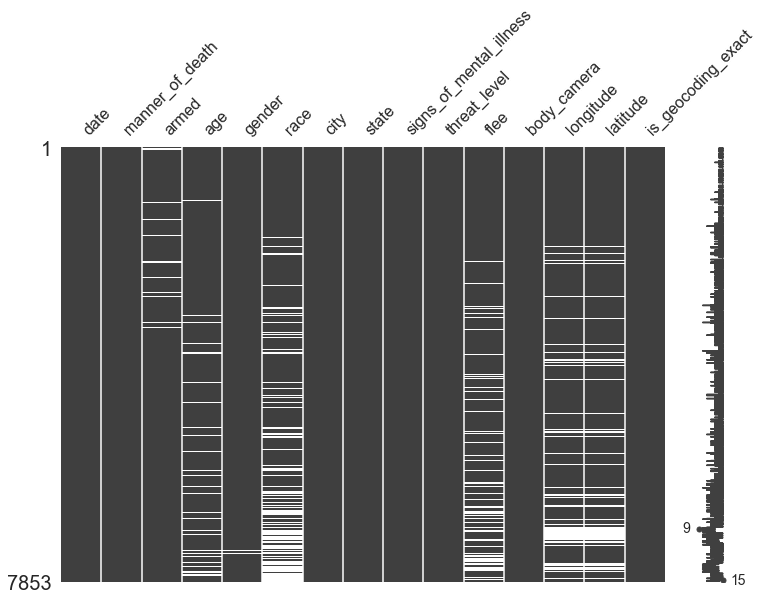

In [337]:
msno.matrix(df, figsize=(12,8))
plt.show()

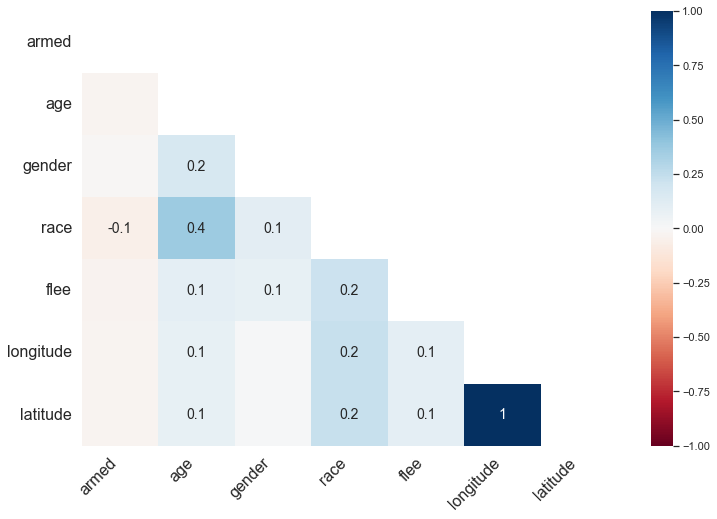

In [338]:
# check if missing data is correlated
msno.heatmap(df, figsize=(12,8))
plt.show()

In [339]:
df['flee'].value_counts()/len(df['flee'])

Not fleeing    0.558131
Car            0.161594
Foot           0.127722
Other          0.037183
Name: flee, dtype: float64

In [340]:
df['gender'].value_counts()/len(df['gender'])

M    0.951738
F    0.044951
Name: gender, dtype: float64

In [341]:
df['race'].value_counts()/len(df['race'])

W    0.408761
B    0.216350
H    0.144913
A    0.014389
N    0.012861
O    0.005858
Name: race, dtype: float64

In [342]:
df[df['age'].isna()]

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
127,2015-02-20,shot,gun,NaN,M,H,Houston,TX,False,attack,Car,False,-95.401,29.983,True
769,2015-10-12,shot,gun,NaN,M,B,Lawton,OK,False,attack,Not fleeing,False,-98.422,34.599,True
809,2015-10-24,shot,gun,NaN,M,NaN,New Paltz,NY,False,attack,Not fleeing,False,-74.080,41.747,True
819,2015-10-29,shot,gun,NaN,M,B,Columbus,OH,False,other,Not fleeing,False,-82.863,39.922,True
932,2015-12-10,shot,gun,NaN,M,NaN,Hemet,CA,False,attack,Not fleeing,False,-116.971,33.729,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,2022-10-21,shot,knife,NaN,M,NaN,Johnstown,CO,False,other,Car,False,-104.983,40.361,True
7844,2022-10-23,shot,gun,NaN,M,NaN,Senatobia,MS,False,other,Other,False,-89.968,34.614,True
7845,2022-10-24,shot,gun,NaN,M,NaN,Castro Valley,CA,False,other,Car,False,-122.011,37.715,True
7847,2022-10-25,shot,knife,NaN,M,NaN,Spring Branch,TX,True,other,Not fleeing,False,-95.480,29.803,True


come back here!!!!

In [343]:
# handle null values

# make null flee 'Not fleeing', as 
df['flee'] = df['flee'].fillna('unknown')

# impute most common gender 'M' for null -- only 4% of shooting are female
#df['gender'] = df['gender'].fillna('M')

# impute 'None' for null race -- 'None' is unknown according to WaPo GitHub
# don't want to make assumptions on race to skew data unnecessarily
df['race'] = df['race'].fillna('None')

# make null age median age of that state
df['age'] = df.groupby('state')['age'].apply(lambda x: x.fillna(x.median()))
#df['age'] = df['age'].fillna('unknown')

# armed null now 'unknown'
df['armed'] = df['armed'].fillna('Unknown')

Only imputed gender and age data with values. Age was imputed using the median age of victims in that state. I chose not to drop null data entirely, but exclude from visualizations when necessary.

Null data is being called 'unknown', except with Race is is 'None'.

In [344]:
# correct data types
df['age'] = df['age'].astype(int)

In [345]:
# T/F values to 1/0
#vals = {True:1, False:0}
#df['body_camera'] = df['body_camera'].map(vals)
#df['signs_of_mental_illness'] = df['signs_of_mental_illness'].map(vals)

manner = {'shot':'shot', 'shot and Tasered':'tasered and shot'}
df['manner_of_death'] = df['manner_of_death'].map(manner)

In [346]:
# Race labels for visualization
race_dict = {'A':'Asian','B':'Black','H':'Hispanic','N':'Native','W':'White','O':'Other','None': 'None'}
df['race'] = df['race'].map(race_dict)

In [347]:
# testing best binning for visualization
# bin age
df['age_binned_11_18'] = pd.cut(x=df['age'], bins=[-np.inf, 18, 25, 30, 35, 40, 45, 50, 55, 60, 66, np.inf], labels=['Under 18','18-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59', '60-65','Over 65'])

# bin age
df['age_binned_11_15'] = pd.cut(x=df['age'], bins=[-np.inf, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 66, np.inf], labels=['Under 15','15-19','20-24','25-29','30-34','35-39','40-44','45-49', '50-54', '55-59','60-65','Over 65'])

# bin age
df['age_binned_7'] = pd.cut(x=df['age'], bins=[-np.inf, 18, 25, 35, 45, 55, 66, np.inf], labels=['Under 18','18-24','25-34','35-44','45-54', '55-65', 'Over 65'])

# bin age
df['age_binned_to_60'] = pd.cut(x=df['age'], bins=[-np.inf, 18, 25, 30, 35, 40, 45, 50, 55, 61, np.inf], labels=['Under 18','18-24','25-29','30-34','35-39','40-44','45-49','50-54','55-60','Over 60'])


In [348]:
# prob not best one
df['age_binned_7_diff'] = pd.cut(x=df['age'], bins=[-np.inf, 18, 30, 40, 50, 60, 71, np.inf], labels=['Under 18','18-29','30-39','40-49','50-59','60-70','Over 70'])


organize armed

count multiple armed in each category and make a note of it

map = {'gun':['gun','guns and explosives','gun and knife','gun and sword','gun and car','gun and machete','machete and gun','gun and vehicle','vehicle and gun','hatchet and gun'],
 'hatchet':['hatchet and gun',]
 'machete': ['machete','gun and machete','machete and gun','ax and machete','vehicle and machete'], 'ax':['ax','ax and machete',],'chainsaw': ['chainsaw', 'chain saw'],
 'car':['car, knife and mace','gun and car'], 'scissors':['pair of scissors','scissors'], 'bb/pellet/beanbag': ['BB gun and vehicle']
 'vehicle':['vehicle','knife and vehicle','gun and vehicle','BB gun and vehicle','motorcycle''vehicle and machete'], 'knife':['pole and knife','baseball bat and knife'], 'baseball bat':['baseball bat and knife',]}



In [349]:
armed_types = df['armed'].unique()

In [350]:
# car, knife and mace
weapons = list()
for a in armed_types:
    count = 0
    if 'bow and arrow' in a:
        count +=1
        weapons.append(a)
        #print(a)
    if ' and' not in a and ',' not in a:
        count+=1
        #print(a)
        weapons.append(a)
    if ' and' in a and ',' in a:
        words = a.split(', ')
        for word in words:
            if 'and' in word:
                ss = word.split(' and ')
                #print(s)
                for s in ss:
                    weapons.append(s)
            else:
                weapons.append(word)
    elif ' and' in a:
        ws = a.split(' and ')
        #print(ws)
        for w in ws:
            #print(w)
            weapons.append(w)
    

In [351]:
type(weapons)

list

In [352]:
len(weapons)

132

In [353]:
list(weapons)

['gun',
 'unarmed',
 'toy weapon',
 'nail gun',
 'knife',
 'Unknown',
 'shovel',
 'vehicle',
 'hammer',
 'hatchet',
 'sword',
 'machete',
 'box cutter',
 'undetermined',
 'metal object',
 'screwdriver',
 'lawn mower blade',
 'flagpole',
 'guns',
 'explosives',
 'cordless drill',
 'crossbow',
 'BB gun',
 'metal pole',
 'Taser',
 'metal pipe',
 'metal hand tool',
 'blunt object',
 'metal stick',
 'sharp object',
 'meat cleaver',
 'carjack',
 'chain',
 "contractor's level",
 'railroad spikes',
 'stapler',
 'beer bottle',
 'unknown weapon',
 'binoculars',
 'pellet gun',
 'bean-bag gun',
 'baseball bat',
 'fireplace poker',
 'straight edge razor',
 'gun',
 'knife',
 'ax',
 'brick',
 'baseball bat',
 'hand torch',
 'chain saw',
 'garden tool',
 'pair of scissors',
 'pole',
 'pick-axe',
 'flashlight',
 'baton',
 'spear',
 'chair',
 'pitchfork',
 'hatchet',
 'gun',
 'rock',
 'piece of wood',
 'pipe',
 'glass shard',
 'motorcycle',
 'pepper spray',
 'metal rake',
 'crowbar',
 'oar',
 'machete',

In [354]:
len(armed_types)

107

In [355]:
df['armed'].value_counts()

gun                    4481
knife                  1120
unarmed                 459
undetermined            327
vehicle                 279
                       ... 
pen                       1
chainsaw                  1
gun and sword             1
claimed to be armed       1
stone                     1
Name: armed, Length: 107, dtype: int64

In [356]:
weapons = pd.Series(weapons)

In [357]:
weapons.value_counts()

gun                   9
knife                 7
vehicle               6
machete               6
baseball bat          4
                     ..
contractor's level    1
chain                 1
carjack               1
meat cleaver          1
stone                 1
Length: 94, dtype: int64

In [358]:
df['armed'].unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', 'Unknown',
       'shovel', 'vehicle', 'hammer', 'hatchet', 'sword', 'machete',
       'box cutter', 'undetermined', 'metal object', 'screwdriver',
       'lawn mower blade', 'flagpole', 'guns and explosives',
       'cordless drill', 'crossbow', 'BB gun', 'metal pole', 'Taser',
       'metal pipe', 'metal hand tool', 'blunt object', 'metal stick',
       'sharp object', 'meat cleaver', 'carjack', 'chain',
       "contractor's level", 'railroad spikes', 'stapler', 'beer bottle',
       'unknown weapon', 'binoculars', 'pellet gun', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chain saw', 'garden tool', 'pair of scissors', 'pole', 'pick-axe',
       'flashlight', 'baton', 'spear', 'chair', 'pitchfork',
       'hatchet and gun', 'rock', 'piece of wood', 'pipe', 'glass shard',
       'motorcycle', 'pepper spray', 'meta

In [359]:
armed = df['armed'].unique()
for i in range(len(df['armed'])):
    if df['armed'][i] == 'chain saw':
        print(df['armed'][i])
        df['armed'][i] = 'chainsaw'
    if df['armed'][i] == 'gun and car':
        df['armed'][i] = 'gun and vehicle'
    if df['armed'][i] == 'vehicle and gun':
        df['armed'][i] = 'gun and vehicle'
    if df['armed'][i] == 'Gun':
        df['armed'][i] = 'gun' 
    if df['armed'][i] == 'stone':
        df['armed'][i] = 'rock'
    else: df['armed'][i] = df['armed'][i]

/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1327169557.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



chain saw


/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1327169557.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



chain saw


/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1327169557.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1327169557.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1327169557.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykerne

In [360]:
df['armed'].unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', 'Unknown',
       'shovel', 'vehicle', 'hammer', 'hatchet', 'sword', 'machete',
       'box cutter', 'undetermined', 'metal object', 'screwdriver',
       'lawn mower blade', 'flagpole', 'guns and explosives',
       'cordless drill', 'crossbow', 'BB gun', 'metal pole', 'Taser',
       'metal pipe', 'metal hand tool', 'blunt object', 'metal stick',
       'sharp object', 'meat cleaver', 'carjack', 'chain',
       "contractor's level", 'railroad spikes', 'stapler', 'beer bottle',
       'unknown weapon', 'binoculars', 'pellet gun', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chainsaw', 'garden tool', 'pair of scissors', 'pole', 'pick-axe',
       'flashlight', 'baton', 'spear', 'chair', 'pitchfork',
       'hatchet and gun', 'rock', 'piece of wood', 'pipe', 'glass shard',
       'motorcycle', 'pepper spray', 'metal

In [361]:
# organizing 'armed' feature by creating difference breakdowns from over 100 different categories
# categories: unarmed (including toy weapon), armed, unknown, undetermined (claimed to be armed and undetermined)

unarmed = ['unarmed', 'toy weapon']
d_unarmed = dict.fromkeys(unarmed, 'unarmed')

armed = ['gun', 'Gun', 'guns and explosives', 'gun and knife','gun and sword', 'gun and car', 'gun and machete', 'vehicle and gun',
         'gun and vehicle', 'nail gun', 'knife', 'shovel', 'vehicle','hammer', 'hatchet', 'sword', 'machete', 'box cutter',
         'metal object', 'screwdriver', 'lawn mower blade', 'flagpole', 'cordless drill', 'crossbow', 'BB gun', 'metal pole',
         'Taser', 'metal pipe', 'metal hand tool', 'blunt object', 'metal stick', 'sharp object', 'meat cleaver','carjack',
         'chain', 'contractors level', 'railroad spikes', 'stapler', 'beer bottle', 'unknown weapon', 'binoculars',
         'pellet gun', 'bean-bag gun', 'baseball bat and fireplace poker', 'straight edge razor', 'ax', 'brick',
         'baseball bat','hand torch', 'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe','flashlight', 'baton',
         'spear', 'chair', 'pitchfork', 'hatchet and gun', 'rock','piece of wood', 'pipe', 'glass shard', 'motorcycle',
         'pepper spray','metal rake', 'crowbar', 'oar', 'machete and gun', 'tire iron', 'air conditioner', 'pole and knife',
         'baseball bat and bottle', 'fireworks','pen', 'chainsaw','incendiary device', 'samurai sword', 'bow and arrow',
         'wrench', 'walking stick', 'barstool', 'grenade','BB gun and vehicle', 'wasp spray', 'air pistol', 'Airsoft pistol',
         'baseball bat and knife', 'vehicle and machete','ice pick','car, knife and mace', 'bottle', 'microphone',
         'knife and vehicle', 'machete and hammer', 'stake', 'incendiary weapon','ax and machete', 'unknown weapon',
         'pair of scissors','hammer and garden tool','flare gun', 'knife, hammer and gasoline can','stone']
d_armed = dict.fromkeys(armed, 'armed')

unk = ['unknown']
d_unk = dict.fromkeys(unk, 'unknown')

undetermined = ['claimed to be armed', 'undetermined']
d_und = dict.fromkeys(undetermined, 'undetermined')

armed_3 = {**d_unarmed, **d_armed, **d_und, **d_unk}

df['armed_3'] = df['armed'].map(armed_3)

In [362]:
# organizing 'armed' feature by creating difference breakdowns from over 100 different categories

unarmed = ['unarmed']
d_unarmed = dict.fromkeys(unarmed, 'unarmed')

toy = ['toy weapon']
d_toy = dict.fromkeys(toy, 'toy weapon')

armed = ['gun', 'Gun', 'guns and explosives', 'gun and knife','gun and sword', 'gun and car', 'gun and machete', 'vehicle and gun',
         'gun and vehicle', 'nail gun', 'knife', 'shovel', 'vehicle','hammer', 'hatchet', 'sword', 'machete', 'box cutter',
         'metal object', 'screwdriver', 'lawn mower blade', 'flagpole', 'cordless drill', 'crossbow', 'BB gun', 'metal pole',
         'Taser', 'metal pipe', 'metal hand tool', 'blunt object', 'metal stick', 'sharp object', 'meat cleaver','carjack',
         'chain', 'contractors level', 'railroad spikes', 'stapler', 'beer bottle', 'unknown weapon', 'binoculars',
         'pellet gun', 'bean-bag gun', 'baseball bat and fireplace poker', 'straight edge razor', 'ax', 'brick',
         'baseball bat','hand torch', 'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe','flashlight', 'baton',
         'spear', 'chair', 'pitchfork', 'hatchet and gun', 'rock','piece of wood', 'pipe', 'glass shard', 'motorcycle',
         'pepper spray','metal rake', 'crowbar', 'oar', 'machete and gun', 'tire iron', 'air conditioner', 'pole and knife',
         'baseball bat and bottle', 'fireworks','pen', 'chainsaw','incendiary device', 'samurai sword', 'bow and arrow',
         'wrench', 'walking stick', 'barstool', 'grenade','BB gun and vehicle', 'wasp spray', 'air pistol', 'Airsoft pistol',
         'baseball bat and knife', 'vehicle and machete','ice pick','car, knife and mace', 'bottle', 'microphone',
         'knife and vehicle', 'machete and hammer', 'stake', 'incendiary weapon','ax and machete', 'unknown weapon',
         'pair of scissors','hammer and garden tool','flare gun','knife, hammer and gasoline can','stone']
d_armed = dict.fromkeys(armed, 'armed')

unk = ['unknown']
d_unk = dict.fromkeys(unk, 'unknown')

undetermined = ['claimed to be armed', 'undetermined']
d_und = dict.fromkeys(undetermined, 'undetermined')

armed_4_toy = {**d_unarmed, **d_armed, **d_und, **d_unk, **d_toy}

df['armed_4_toy'] = df['armed'].map(armed_4_toy)

In [363]:
# differentiate guns
unarmed = ['unarmed', 'toy weapon']
d_unarmed = dict.fromkeys(unarmed, 'unarmed')

armed_gun = ['gun', 'Gun', 'guns and explosives', 'gun and knife','gun and sword', 'gun and car', 'gun and machete', 'vehicle and gun',
         'gun and vehicle']
d_armed_gun = dict.fromkeys(armed_gun, 'gun')

armed_other = ['nail gun', 'knife', 'shovel', 'vehicle','hammer', 'hatchet', 'sword', 'machete', 'box cutter',
         'metal object', 'screwdriver', 'lawn mower blade', 'flagpole', 'cordless drill', 'crossbow', 'BB gun', 'metal pole',
         'Taser', 'metal pipe', 'metal hand tool', 'blunt object', 'metal stick', 'sharp object', 'meat cleaver','carjack',
         'chain', 'contractors level', 'railroad spikes', 'stapler', 'beer bottle', 'unknown weapon', 'binoculars',
         'pellet gun', 'bean-bag gun', 'baseball bat and fireplace poker', 'straight edge razor', 'ax', 'brick',
         'baseball bat','hand torch', 'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe','flashlight', 'baton',
         'spear', 'chair', 'pitchfork', 'hatchet and gun', 'rock','piece of wood', 'pipe', 'glass shard', 'motorcycle',
         'pepper spray','metal rake', 'crowbar', 'oar', 'machete and gun', 'tire iron', 'air conditioner', 'pole and knife',
         'baseball bat and bottle', 'fireworks','pen', 'chainsaw','incendiary device', 'samurai sword', 'bow and arrow',
         'wrench', 'walking stick', 'barstool', 'grenade','BB gun and vehicle', 'wasp spray', 'air pistol', 'Airsoft pistol',
         'baseball bat and knife', 'vehicle and machete','ice pick','car, knife and mace', 'bottle', 'microphone',
         'knife and vehicle', 'machete and hammer', 'stake', 'incendiary weapon','ax and machete', 'unknown weapon','pair of scissors','hammer and garden tool','flare gun', 'knife, hammer and gasoline can','stone']
d_armed_other = dict.fromkeys(armed_other, 'other weapon')

unk = ['unknown']
d_unk = dict.fromkeys(unk, 'unknown')

undetermined = ['claimed to be armed', 'undetermined']
d_und = dict.fromkeys(undetermined, 'undetermined')

armed_4 = {**d_unarmed, **d_armed_gun, **d_armed_other, **d_und, **d_unk}

df['armed_4'] = df['armed'].map(armed_4)

In [364]:
# differentiate guns
unarmed = ['unarmed']
d_unarmed = dict.fromkeys(unarmed, 'unarmed')

toy = ['toy weapon']
d_toy = dict.fromkeys(toy, 'toy weapon')

armed_gun = ['gun', 'Gun', 'guns and explosives', 'gun and knife','gun and sword', 'gun and car', 'gun and machete', 'vehicle and gun',
         'gun and vehicle']
d_armed_gun = dict.fromkeys(armed_gun, 'gun')

armed_other = ['nail gun', 'knife', 'shovel', 'vehicle','hammer', 'hatchet', 'sword', 'machete', 'box cutter',
         'metal object', 'screwdriver', 'lawn mower blade', 'flagpole', 'cordless drill', 'crossbow', 'BB gun', 'metal pole',
         'Taser', 'metal pipe', 'metal hand tool', 'blunt object', 'metal stick', 'sharp object', 'meat cleaver','carjack',
         'chain', 'contractors level', 'railroad spikes', 'stapler', 'beer bottle', 'unknown weapon', 'binoculars',
         'pellet gun', 'bean-bag gun', 'baseball bat and fireplace poker', 'straight edge razor', 'ax', 'brick',
         'baseball bat','hand torch', 'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe','flashlight', 'baton',
         'spear', 'chair', 'pitchfork', 'hatchet and gun', 'rock','piece of wood', 'pipe', 'glass shard', 'motorcycle',
         'pepper spray','metal rake', 'crowbar', 'oar', 'machete and gun', 'tire iron', 'air conditioner', 'pole and knife',
         'baseball bat and bottle', 'fireworks','pen', 'chainsaw','incendiary device', 'samurai sword', 'bow and arrow',
         'wrench', 'walking stick', 'barstool', 'grenade','BB gun and vehicle', 'wasp spray', 'air pistol', 'Airsoft pistol',
         'baseball bat and knife', 'vehicle and machete','ice pick','car, knife and mace', 'bottle', 'microphone',
         'knife and vehicle', 'machete and hammer', 'stake', 'incendiary weapon','ax and machete', 'unknown weapon', 'pair of scissors','hammer and garden tool','flare gun', 'knife, hammer and gasoline can','stone']
d_armed_other = dict.fromkeys(armed_other, 'other weapon')

unk = ['unknown']
d_unk = dict.fromkeys(unk, 'unknown')

undetermined = ['claimed to be armed', 'undetermined']
d_und = dict.fromkeys(undetermined, 'undetermined')

armed_5_toy = {**d_unarmed, **d_armed_gun, **d_armed_other, **d_und, **d_unk, **d_toy}

df['armed_5_toy'] = df['armed'].map(armed_5_toy)

In [365]:
# further stratified
unarmed = ['unarmed', 'toy weapon']
d_unarmed = dict.fromkeys(unarmed, 'unarmed')

gun = ['gun', 'Gun', 'guns and explosives', 'gun and knife','gun and sword', 'gun and car', 'gun and machete', 
           'vehicle and gun', 'gun and vehicle']
d_gun = dict.fromkeys(gun, 'gun')

knife = ['knife','hatchet','sword','machete','box cutter', 'lawn mower blade','sharp object', 'meat cleaver',
    'straight edge razor', 'ax', 'chain saw', 'garden tool', 'scissors', 'pick-axe','spear', 'pitchfork', 'hatchet and gun', 'machete and gun', 'pole and knife', 
    'chainsaw','samurai sword','baseball bat and knife', 'vehicle and machete', 'ice pick','car, knife and mace', 'knife and vehicle', 'machete and hammer',
    'ax and machete', 'pair of scissors','knife, hammer and gasoline can']
d_knives = dict.fromkeys(knife, 'knife/cutting instrument')

# separated toy guns from airsoft, bb guns, and pellet guns
air_bb = ['BB gun', 'pellet gun', 'BB gun and vehicle', 'air pistol', 'Airsoft pistol']
d_air_bb = dict.fromkeys(air_bb, 'air/bb/pellet guns')

toy = ['toy weapon']
d_toy = dict.fromkeys(toy, 'toy weapon')

other = ['nail gun', 'shovel', 'vehicle','hammer', 'metal object', 'screwdriver', 'flagpole', 'cordless drill',
         'crossbow','metal pole','Taser', 'metal pipe', 'metal hand tool','blunt object', 'metal stick','carjack',
         'chain', 'contractors level', 'railroad spikes', 'stapler', 'beer bottle', 'unknown weapon','binoculars',
         'bean-bag gun', 'baseball bat and fireplace poker', 'brick', 'baseball bat','hand torch','pole', 'flashlight',
         'baton','chair','pitchfork', 'rock','piece of wood', 'pipe', 'glass shard', 'motorcycle', 'pepper spray',
         'metal rake', 'crowbar', 'oar', 'tire iron', 'air conditioner', 'baseball bat and bottle', 'fireworks',
         'pen','incendiary device', 'bow and arrow', 'wrench', 'walking stick','barstool', 'grenade', 'wasp spray',
         'bottle', 'microphone','stake','stone','incendiary weapon','unknown weapon','hammer and garden tool', 'flare gun'] 
d_other = dict.fromkeys(other, 'other weapon')

unk = ['unknown']
d_unk = dict.fromkeys(unk, 'unknown')

undetermined: ['claimed to be armed', 'undetermined']
d_undet = dict.fromkeys(undetermined, 'undetermined')

armed_7 = {**d_unarmed, **d_gun, **d_knives, **d_air_bb, **d_toy, **d_other, **d_undet, **d_unk}

df['armed_7'] = df['armed'].map(armed_7)

'armed' is often updated with a specific weapon not otherwise in the list, causing null values in engineered columns.

'undetermined' includes 'undetermined' and 'claimed to be armed'

'armed_other' includes (explosives, fire, blunt objects, melee weapons, bean bag gun)

In [366]:
na = df[df['armed_3'].isna()]
df['armed'].isna().sum()

0

In [367]:
# may appear as if null values in calculated armed columns due to 'Unknown' being counted as null

*threat_level:* The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. Other includes many incidents where officers or others faced significant threats.

*is_geocoding_exact:* False means centroid area [lat,long]; True means [lat,long] within approximately 100 meters

to use in tableau, will be filling latitude and longitude that is missing with lat,long of city as my analysis is not further stratified than that

In [368]:
# make thing to add (lat,long)
# get list of cities of missing long
# get csv of (lat,long) of those cities
# mesh together

In [369]:
missing_long_city = nolongitude[['city', 'state']].value_counts()

In [370]:
missing_long_city

city               state
Los Angeles        CA       17
Phoenix            AZ       15
Houston            TX        9
New York           NY        8
Albuquerque        NM        7
                            ..
Garland            TX        1
Gastonia           NC        1
Georgetown County  SC        1
Ghent              KY        1
Еasley             SC        1
Length: 660, dtype: int64

In [371]:
type(missing_long_city)

pandas.core.series.Series

In [372]:
df['count'] = 1

In [373]:
# make MM-YY column from date
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
# make YY column from date
df['year'] = df['date'].dt.year
# make quarter column from date
df['quarter'] = df['date'].dt.quarter

In [374]:
# make separate df with latitude and longitude and remove from df
coord_df = df.copy()
df.drop(columns=['latitude','longitude'], inplace=True)
coord_df['latitude'] = coord_df['latitude'].astype(float)
coord_df['longitude'] = coord_df['longitude'].astype(float)

In [375]:
coord_df.isna().sum()

date                         0
manner_of_death              0
armed                        0
age                          0
gender                      26
race                         0
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
longitude                  841
latitude                   841
is_geocoding_exact           0
age_binned_11_18             0
age_binned_11_15             0
age_binned_7                 0
age_binned_to_60             0
age_binned_7_diff            0
armed_3                    210
armed_4_toy                210
armed_4                    210
armed_5_toy                210
armed_7                    210
count                        0
month                        0
year                         0
quarter                      0
dtype: int64

In [376]:
df.isna().sum()

date                         0
manner_of_death              0
armed                        0
age                          0
gender                      26
race                         0
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
is_geocoding_exact           0
age_binned_11_18             0
age_binned_11_15             0
age_binned_7                 0
age_binned_to_60             0
age_binned_7_diff            0
armed_3                    210
armed_4_toy                210
armed_4                    210
armed_5_toy                210
armed_7                    210
count                        0
month                        0
year                         0
quarter                      0
dtype: int64

In [377]:
coord_df.columns

Index(['date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city',
       'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'age_binned_11_18', 'age_binned_11_15', 'age_binned_7',
       'age_binned_to_60', 'age_binned_7_diff', 'armed_3', 'armed_4_toy',
       'armed_4', 'armed_5_toy', 'armed_7', 'count', 'month', 'year',
       'quarter'],
      dtype='object')

# adding census data

In [378]:
state_pop19 = pd.read_csv('../Fatal-Police-Shootings-WaPo/data/UnprocessedCensusData/statepop/nst-est2019-popchg2010_2019.csv')

In [379]:
# create state population dataframe
state_pop = pd.DataFrame(columns=['state_name', 'PopEstimate2015', 'PopEstimate2016', 'PopEstimate2017', 'PopEstimate2018', 'PopEstimate2019'])
state_pop[['state_name', 'PopEstimate2015', 'PopEstimate2016', 'PopEstimate2017', 'PopEstimate2018', 'PopEstimate2019']] = state_pop19[['NAME','POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019']]
# drop regions and PR
state_pop.drop(axis=0, index=[1,2,3,4,56], inplace=True)
state_pop.reset_index(drop=True,inplace=True)

In [380]:
state_pop20_21 = pd.read_csv('../Fatal-Police-Shootings-WaPo/data/UnprocessedCensusData/statepop/NST-EST2021-popchg2020_2021.csv')

In [381]:
state_pop20_21.drop(axis=0, index=[1,2,3,4,56], inplace=True)
state_pop20_21.reset_index(drop=True, inplace=True)

state_pop[['PopEstimate2020', 'PopEstimate2021']] = state_pop20_21[['POPESTIMATE2020', 'POPESTIMATE2021']]

In [382]:
state_abbrev = {'United States':'Total', 'Alabama':'AL', 'Alaska':'AK', 'Arizona':'AZ', 'Arkansas':'AR', 
                'California':'CA','Colorado':'CO', 'Connecticut':'CT', 'Delaware':'DE','District of Columbia':'DC',
                'Florida':'FL', 'Georgia':'GA', 'Hawaii':'HI', 'Idaho':'ID', 'Illinois': 'IL','Indiana': 'IN',
                'Iowa':'IA', 'Kansas':'KS', 'Kentucky':'KY', 'Louisiana':'LA', 'Maine':'ME', 'Maryland':'MD', 
                'Massachusetts':'MA', 'Michigan':'MI', 'Minnesota':'MN', 'Mississippi':'MS', 'Missouri': 'MO',
                'Montana': 'MT', 'Nebraska':'NE', 'Nevada':'NV', 'New Hampshire':'NH','New Jersey':'NJ', 'New Mexico':'NM',
                'New York':'NY', 'North Carolina':'NC', 'North Dakota':'ND','Ohio':'OH','Oklahoma':'OK', 'Oregon':'OR',
                'Pennsylvania':'PA', 'Rhode Island':'RI', 'South Carolina':'SC','South Dakota':'SD','Tennessee':'TN',
                'Texas':'TX', 'Utah':'UT','Vermont':'VT','Virginia':'VA','Washington':'WA', 'West Virginia':'WV',
                'Wisconsin':'WI', 'Wyoming':'WY'}

state_pop['state'] = state_pop['state_name'].map(state_abbrev)

In [383]:
state_pop.set_index(keys='state', inplace=True)

In [384]:
# merge state pop data
df = pd.merge(df, state_pop, on='state')
coord_df = pd.merge(coord_df, state_pop, on='state')

intial findings

# Exploratory data analysis

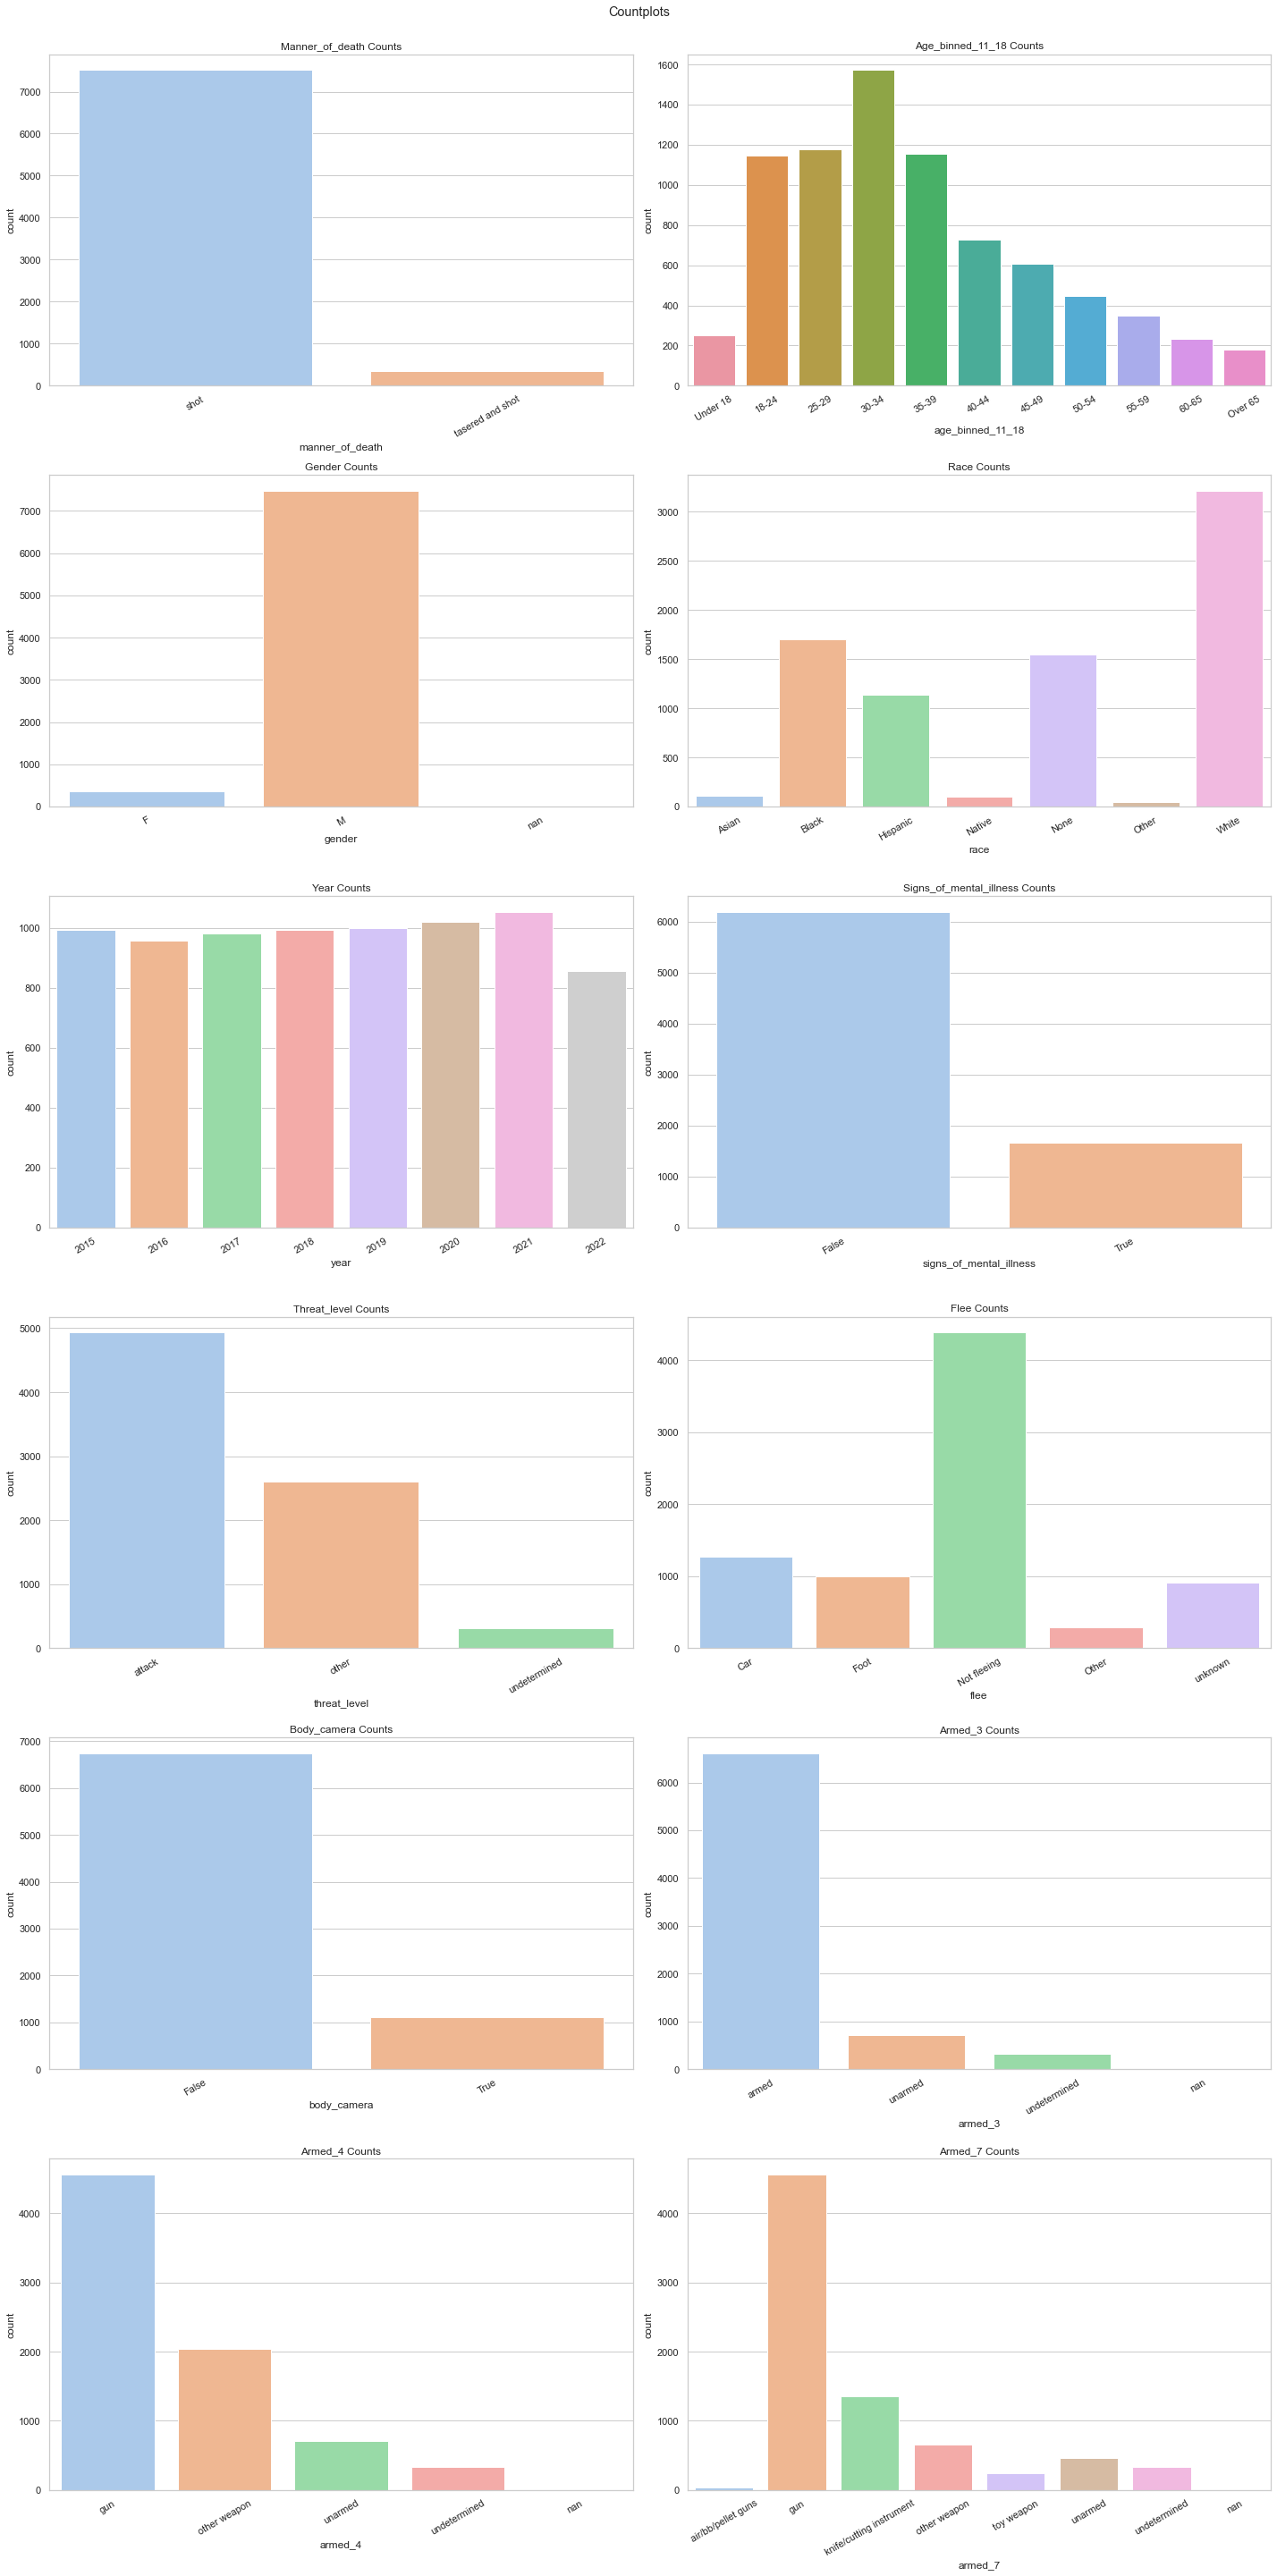

In [385]:
# plot distributions
columns = [['manner_of_death', 'age_binned_11_18'], ['gender', 'race'],['year', 'signs_of_mental_illness'],
           ['threat_level','flee'], ['body_camera', 'armed_3'], ['armed_4', 'armed_7']]

def countplots(cols):
    fig, axes = plt.subplots(6, 2, figsize=(20, 40), squeeze=True)
    fig.suptitle('Countplots',y=1)
    for row in range(6):
        for col in range(2):
            column = cols[row][col]
            p = sns.countplot(x=df[column],ax=axes[row,col], order=df.sort_values(by=column)[column].unique())
            p.set_xticks(range(len(df[column].unique())))
            p.set_xticklabels(labels=df.sort_values(by=column)[column].unique(), rotation=30)
            axes[row,col].set_title(f'{column.capitalize()} Counts')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.tight_layout()
    plt.show()
    
countplots(columns)

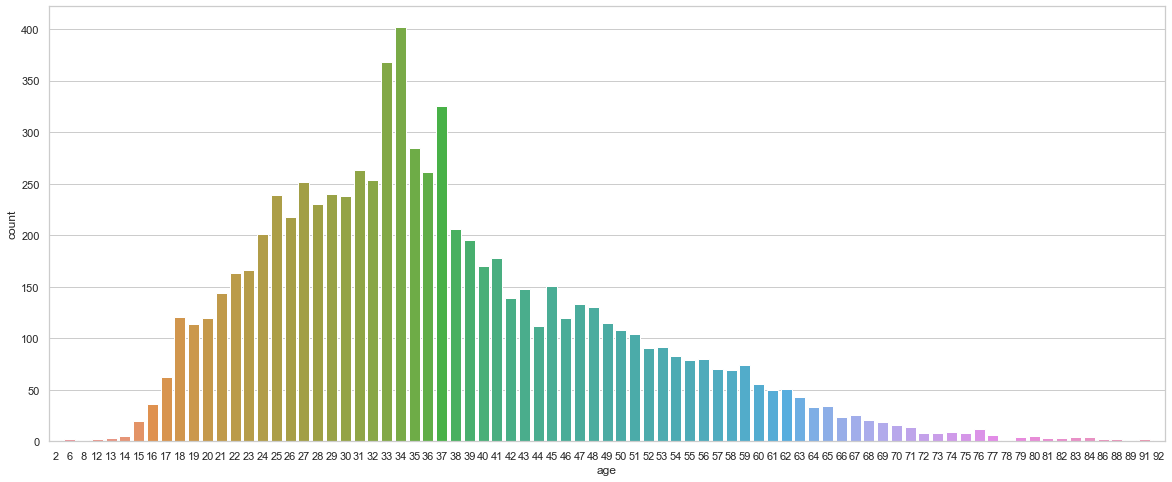

In [386]:
fig, ax = plt.subplots(figsize = (20,8))
sns.countplot(x='age', data=df)
plt.show()

In [390]:
# 30-44 year olds are the largest age group represented with 43.9% of deaths, followed by 18-29 year olds with 29.7%
df['age_binned_7'].value_counts()/len(df['age_binned_7'])

25-34       0.350185
35-44       0.240036
18-24       0.146059
45-54       0.134344
55-65       0.074366
Under 18    0.032217
Over 65     0.022794
Name: age_binned_7, dtype: float64

In [391]:
df['age_binned_11_18'].value_counts()/len(df['age_binned_11_18'])

30-34       0.200178
25-29       0.150006
35-39       0.147332
18-24       0.146059
40-44       0.092703
45-49       0.077168
50-54       0.057176
55-59       0.044442
Under 18    0.032217
60-65       0.029925
Over 65     0.022794
Name: age_binned_11_18, dtype: float64

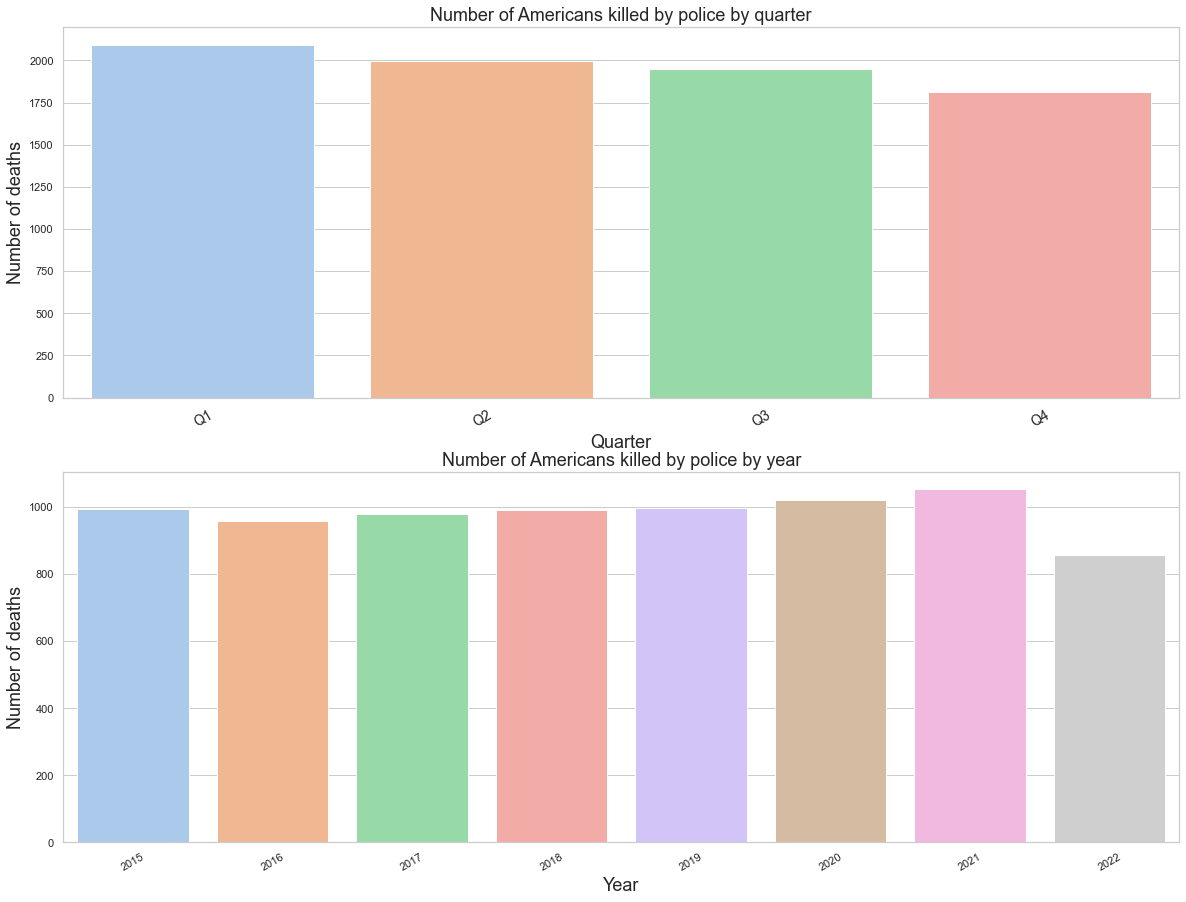

In [392]:
fig, ax = plt.subplots(2,1, figsize=(20,15))

#state_dist = sns.countplot(x = df.sort_values(by='state')['state'], ax=ax[0])
#state_dist.set_xticklabels(labels=df.sort_values(by='state')['state'].unique(), rotation=30)
#state_dist.set_title('Police shooting deaths by state', fontsize=18)
#state_dist.set_xlabel('State', fontsize=18)
#state_dist.set_ylabel('Number of deaths', fontsize=18)

quarter_dist = sns.countplot(x = df.sort_values(by='quarter')['quarter'], data=df,ax=ax[0])
quarter_dist.set_xticklabels(labels=df.sort_values(by='quarter')['quarter'].unique(), rotation=30)
quarter_dist.set_title('Number of Americans killed by police by quarter', fontsize=18)
quarter_dist.set_xlabel('Quarter', fontsize=18)
quarter_dist.set_xticks(ticks=[0,1,2,3],labels=['Q1','Q2','Q3','Q4'], fontsize=14)
quarter_dist.set_ylabel('Number of deaths', fontsize=18)

year_dist = sns.countplot(x = df.sort_values(by='year')['year'], data=df,ax=ax[1])
year_dist.set_xticklabels(labels=df.sort_values(by='year')['year'].unique(), rotation=30)
year_dist.set_title('Number of Americans killed by police by year', fontsize=18)
year_dist.set_xlabel('Year', fontsize=18)
year_dist.set_ylabel('Number of deaths', fontsize=18)

plt.show()

In [393]:
months = df.month.value_counts()

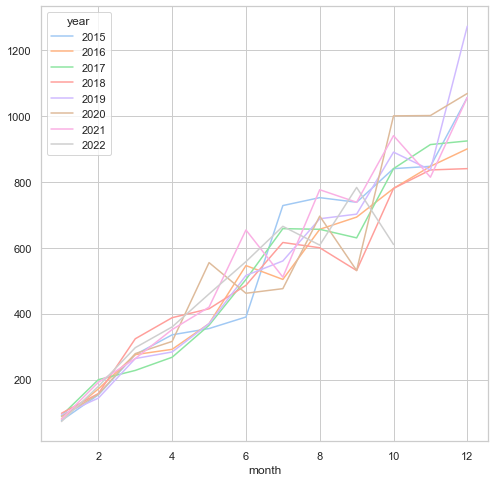

In [394]:
# pivot table summing is off
df.pivot_table(index='month', columns='year', values='count', aggfunc={'month':'sum'}).plot(figsize=(8,8))                                                                             
plt.show()

In [395]:
d = df.groupby([df.month, df.year])['count'].sum()

In [396]:
d = d.unstack().cumsum()

In [397]:
d

year,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,
1,76.0,81.0,91.0,98.0,93.0,88.0,80.0,73.0
2,153.0,167.0,191.0,177.0,165.0,166.0,176.0,163.0
3,245.0,259.0,267.0,285.0,253.0,259.0,264.0,262.0
4,329.0,332.0,334.0,382.0,324.0,338.0,352.0,352.0
5,400.0,406.0,407.0,465.0,398.0,449.0,436.0,444.0
6,465.0,497.0,491.0,546.0,484.0,526.0,545.0,537.0
7,569.0,569.0,585.0,634.0,564.0,594.0,618.0,632.0
8,663.0,651.0,667.0,709.0,650.0,681.0,715.0,708.0
9,745.0,728.0,737.0,768.0,728.0,740.0,797.0,795.0


In [398]:
# cumulative sum is off in this table

#pivoted = df.pivot_table(index='month', columns='year', values='count', aggfunc={'month':'sum'})#.plot(figsize=(15,10))                                                                             
#plt.legend(loc='lower right')
#plt.show()
# count or sum for aggfunc
#pivoted

In [399]:
pivoted = df.pivot_table(index='month', columns='year', values='count', aggfunc={'count':'sum'})#.plot(figsize=(15,10))                                                                             
#plt.legend(loc='lower right')
#plt.show()
# count or sum for aggfunc
pivoted

year,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,
1,76.0,81.0,91.0,98.0,93.0,88.0,80.0,73.0
2,77.0,86.0,100.0,79.0,72.0,78.0,96.0,90.0
3,92.0,92.0,76.0,108.0,88.0,93.0,88.0,99.0
4,84.0,73.0,67.0,97.0,71.0,79.0,88.0,90.0
5,71.0,74.0,73.0,83.0,74.0,111.0,84.0,92.0
6,65.0,91.0,84.0,81.0,86.0,77.0,109.0,93.0
7,104.0,72.0,94.0,88.0,80.0,68.0,73.0,95.0
8,94.0,82.0,82.0,75.0,86.0,87.0,97.0,76.0
9,82.0,77.0,70.0,59.0,78.0,59.0,82.0,87.0


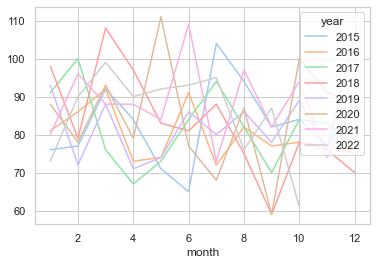

In [400]:
pivoted.plot()
plt.show()

In [401]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=d.index, y=d[2015],
                    mode='lines+markers',
                    name='2015', line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2016], name = '2016',
                         line=dict(color='orangered', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2017], name = '2017',
                         line=dict(color='pink', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2018], name = '2018',
                         line=dict(color='lightseagreen', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2019], name = '2019',
                         line=dict(color='powderblue', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2020], name = '2020',
                         line=dict(color='purple', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2021], name = '2021',
                         line=dict(color='gray', width=4)))
fig.add_trace(go.Scatter(x=d.index, y=d[2022], name = '2022',
                         line=dict(color='mediumorchid', width=4)))

fig.update_layout(title={'text': 'Fatal Police Shootings by Year', 'xanchor': 'center', 'yanchor': 'top','y':0.9,
                         'x':0.45}, xaxis_title="Month", yaxis_title="Number of People Killed",
                  legend_title={'text': 'Year'}, font=dict(family="Courier New, monospace", size=16, color="RebeccaPurple"))

fig.show()

more exploratory 

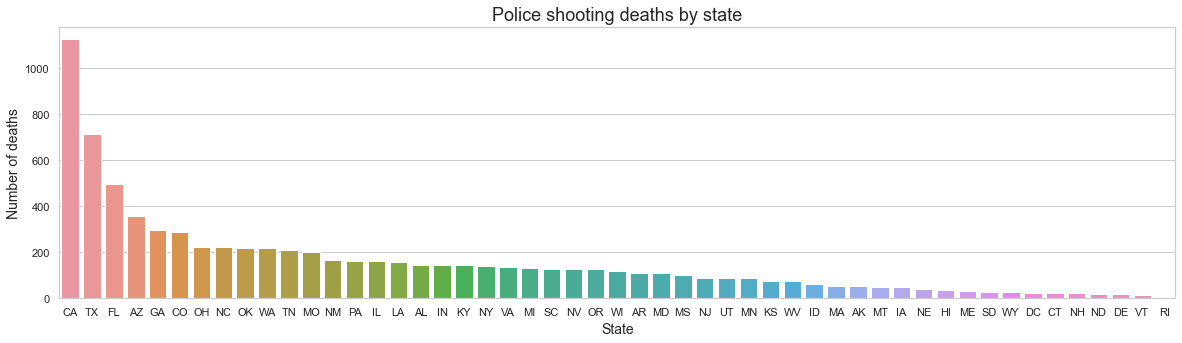

In [402]:
shot_by_state = df.state.value_counts()

plt.figure(figsize=(20, 5))
plt.title('Police shooting deaths by state', fontsize=18)
sns.barplot(shot_by_state.index, shot_by_state)
plt.ylabel('Number of deaths', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.show()

In [403]:
# plot total killings (2015-2022) by state per 100,000 people of that state (using 2020 population)
state_pop_2020 = state_pop['PopEstimate2020'].drop('Total').sort_index(ascending=True)
shot_by_state = df.state.value_counts().sort_index(ascending=True)

In [404]:
adj_shot_by_state = round(shot_by_state/(state_pop_2020/100000), 2).sort_values(ascending=False)
adj_shot_by_state.head(5)

NM    7.89
AK    7.24
OK    5.53
CO    4.98
AZ    4.96
dtype: float64

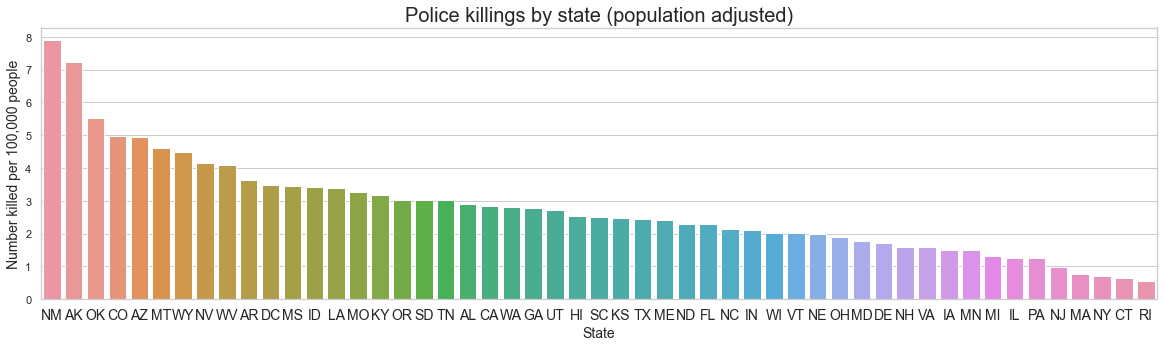

In [405]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(adj_shot_by_state.index, adj_shot_by_state, ax=ax)
plt.title('Police killings by state (population adjusted)', fontsize=20)
plt.xlabel('State', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number killed per 100,000 people', fontsize=14)
plt.show()

In [406]:
# very different from states with actual highest number of killings (higher population states)

In [407]:
shot_by_city = df.city.value_counts()
shot_by_city_top20 = shot_by_city.head(20)

In [408]:
len(df['city'])

7853

In [409]:
len(shot_by_city)

3183

In [410]:
df[df.city.duplicated()]

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,...,year,quarter,state_name,PopEstimate2015,PopEstimate2016,PopEstimate2017,PopEstimate2018,PopEstimate2019,PopEstimate2020,PopEstimate2021
9,2015-08-05,shot,gun,40,M,White,Tacoma,WA,False,attack,...,2015,3,Washington,7163657,7294771,7423362,7523869,7614893,7718785,7738692
14,2015-12-06,shot,gun,35,M,White,Seattle,WA,False,attack,...,2015,4,Washington,7163657,7294771,7423362,7523869,7614893,7718785,7738692
19,2016-01-28,shot,vehicle,32,F,Native,Tacoma,WA,False,other,...,2016,1,Washington,7163657,7294771,7423362,7523869,7614893,7718785,7738692
20,2016-02-20,shot,gun,41,M,Black,Lakewood,WA,False,attack,...,2016,1,Washington,7163657,7294771,7423362,7523869,7614893,7718785,7738692
21,2016-02-21,shot,undetermined,46,M,Black,Seattle,WA,False,other,...,2016,1,Washington,7163657,7294771,7423362,7523869,7614893,7718785,7738692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,2021-08-05,shot,unarmed,35,M,None,Hartford,VT,False,attack,...,2021,3,Vermont,625216,623657,624344,624358,623989,642495,645570
7844,2021-08-25,shot,undetermined,33,M,None,Rutland,VT,False,other,...,2021,3,Vermont,625216,623657,624344,624358,623989,642495,645570
7846,2022-08-15,shot,gun and vehicle,35,M,White,Ludlow,VT,True,attack,...,2022,3,Vermont,625216,623657,624344,624358,623989,642495,645570
7850,2018-09-07,shot,gun,28,M,Black,Pawtucket,RI,False,attack,...,2018,3,Rhode Island,1056065,1056770,1055673,1058287,1059361,1096229,1095610


In [411]:
df.city.nunique()

3183

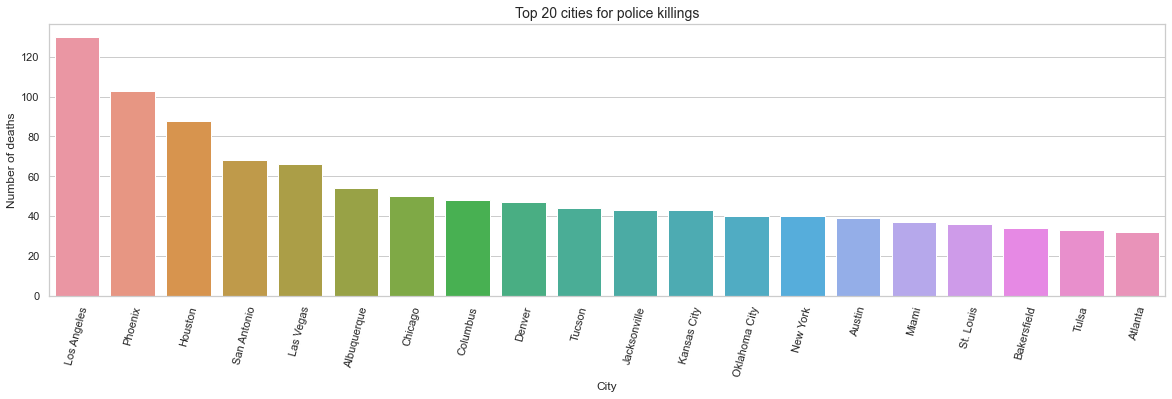

In [412]:
plt.figure(figsize=(20, 5))
plt.title('Top 20 cities for police killings', fontsize=14)
plt.xticks(rotation=75)
sns.barplot(shot_by_city_top20.index, shot_by_city_top20)
plt.ylabel('Number of deaths', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.show()

In [413]:
k = df.groupby([df.state, df.city])['count'].sum().sort_values(ascending=False)
k.head()

state  city       
CA     Los Angeles    130
AZ     Phoenix        102
TX     Houston         87
       San Antonio     68
NV     Las Vegas       65
Name: count, dtype: int64

In [414]:
ks = k.unstack(level=-1,fill_value=0)

In [415]:
ks.index

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [416]:
ks.head(20)

city,300 block of State Line Road,Abbeville,Aberdeen,Abilene,Abingdon,Abington Township,Acworth,Ada,Adams,Adams County,...,Youngstown,Youngtown,Yreka,Yuba City,Yucca Valley,Yulee,Yuma,Zanesville,Zion,Еasley
state,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZ,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,5,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,3,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [417]:
coord_df['city/state'] = coord_df['city'] + ', ' + coord_df['state']
df['city/state'] = df['city'] + ', ' + df['state']

In [418]:
df['city/state'].value_counts()

Los Angeles, CA    130
Phoenix, AZ        102
Houston, TX         87
San Antonio, TX     68
Las Vegas, NV       65
                  ... 
Dover, AR            1
Desha, AR            1
Bull Shoals, AR      1
Sheridan, AR         1
Woonsocket, RI       1
Name: city/state, Length: 3676, dtype: int64

In [419]:
#top20_cams.groupby(['city','year'])
top20_cams_by_year = df.groupby([df.city, df.year])['count','body_camera'].sum().sort_values(by='count', ascending=False)
cams_by_city = df.groupby([df.city])['count','body_camera'].sum().sort_values(by='count', ascending=False)

In [420]:
top20_cams = cams_by_city[:20]

In [421]:
top20_cams

,count,body_camera
city,,
Los Angeles,130,26
Phoenix,103,16
Houston,88,21
San Antonio,68,12
Las Vegas,66,29
Albuquerque,54,10
Chicago,50,12
Columbus,48,8
Denver,47,2


In [422]:
top20_cams['no_body_camera'] = top20_cams['count'] - top20_cams['body_camera']

/var/folders/v_/wdytmqyx1377p1m8yrz0tdrr0000gn/T/ipykernel_2845/1872087179.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [423]:
len(top20_cams['body_camera'])

20

In [424]:
len(top20_cams)

20

In [425]:
top20_cam = top20_cams.groupby(['city', 'no_body_camera', 'body_camera']).size().reset_index()

In [426]:
top20_cams

,count,body_camera,no_body_camera
city,,,
Los Angeles,130,26,104
Phoenix,103,16,87
Houston,88,21,67
San Antonio,68,12,56
Las Vegas,66,29,37
Albuquerque,54,10,44
Chicago,50,12,38
Columbus,48,8,40
Denver,47,2,45


In [427]:
#top20_cams['percent'] = top20_cams['body_camera'] / top20_cams['count']
#top20_cam['percent'] = top20_cams.groupby(['no_body_camera', 'body_camera']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
#text = top20_cams['percent'].apply(lambda x: '{0:1.2f}%'.format(x))
#top20_cams['percent_no'] = top20_cams['no_body_camera'] / top20_cams['count']


In [428]:
top20_cams

,count,body_camera,no_body_camera
city,,,
Los Angeles,130,26,104
Phoenix,103,16,87
Houston,88,21,67
San Antonio,68,12,56
Las Vegas,66,29,37
Albuquerque,54,10,44
Chicago,50,12,38
Columbus,48,8,40
Denver,47,2,45


In [429]:
# rates of body cam usage in top 20 cities
# stacked bar plot
fig = px.histogram(top20_cams, x=top20_cams.index, y=['no_body_camera','body_camera'],
             title='Body Camera Usage in Top 20 Cities for Police Killings', barnorm='percent', text_auto='.1f')
fig.update_layout(xaxis={'categoryorder':'total descending'}, yaxis={"ticksuffix":"%"})
fig.show()

In [430]:
# rates of body cam usage in top 20 cities
# stacked bar plot
fig = px.histogram(top20_cams, x=top20_cams.index, y=['no_body_camera','body_camera'],
             title='Body Camera Usage in Top 20 Cities for Police Killings')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [431]:
cities = list(top20_cams.index)
top20_race = df.loc[df['city'].isin(cities)]

In [432]:
# rates of body cam usage in top 20 cities
# stacked bar plot
fig = px.histogram(top20_race, x='body_camera', y='count', color='race', title='Race Breakdown of Body Camera Usage - Top 20 Cities',
                   category_orders={'race':['White', 'Black', 'Hispanic', 'Asian', 'Native', 'Other', 'None']},
                   barnorm='percent', text_auto='.1f')
fig.update_layout(xaxis={'categoryorder':'total descending'}, yaxis={"ticksuffix":"%"})
fig.show()

In [433]:
# rates of body cam usage in top 20 cities
# stacked bar plot
fig = px.histogram(df, x='body_camera', y='count', color='race', title='Race Breakdown of Body Camera Usage',
                   category_orders={'race':['White', 'Black', 'Hispanic', 'Asian', 'Native', 'Other', 'None']},
                   barnorm='percent', text_auto='.1f')
fig.update_layout(xaxis={'categoryorder':'total descending'}, yaxis={"ticksuffix":"%"})
fig.show()

In [434]:
# with a body camera present or not, Black people are killed by police at a higher rate than the proportion of 
# the total population they compose.

In [435]:
# rates of body cam usage in top 20 cities
# stacked bar plot
fig = px.histogram(top20_race, x='city', y='count', color='race', title='Police Killings by Race - Top 20 Cities',
                  barnorm='percent', text_auto='.1f', category_orders={'race':['White', 'Black', 'Hispanic', 'Asian', 'Native', 'Other', 'None']})
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide', xaxis={'categoryorder':'total descending'},
                  xaxis_title='City', yaxis_title='Percent of Total', yaxis={"ticksuffix":"%"}, legend_title='Race')
fig.show()

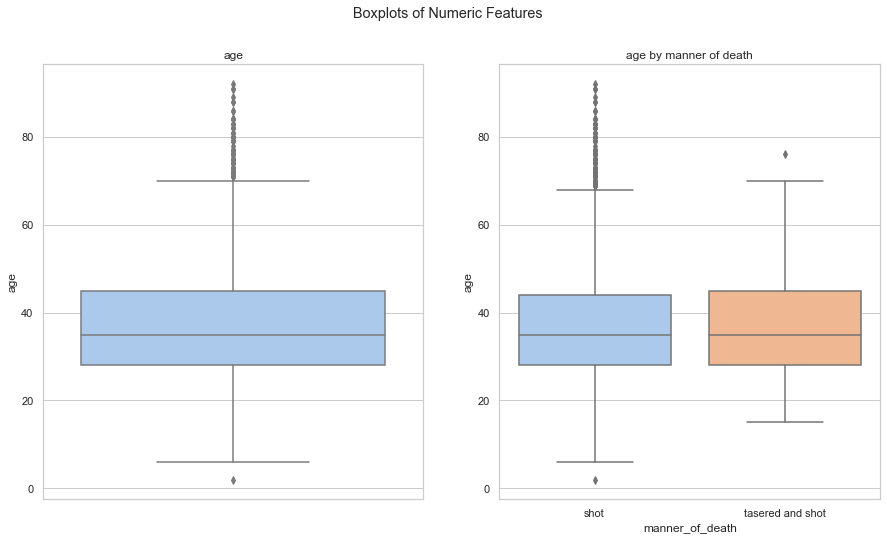

In [436]:
# box plots of Age
fig, ax = plt.subplots(1,2, figsize=(15,8))
plt.suptitle('Boxplots of Numeric Features')
sns.boxplot(y='age', data=df, ax=ax[0])
ax[0].set_title('age')

sns.boxplot(y='age',x='manner_of_death', data=df, ax=ax[1])
ax[1].set_title('age by manner of death')
plt.show()

In [437]:
# the police don't appear to utilize tasers in their very youngest and oldest encounters that result in shooting death

In [438]:
shot_by_race = df['race'].value_counts()

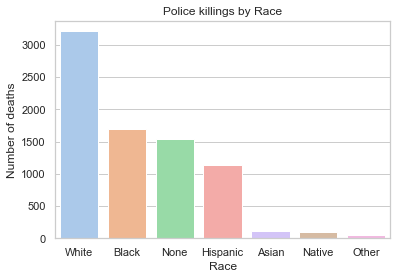

In [439]:
plt.title("Police killings by Race")
sns.barplot(shot_by_race.index, shot_by_race)
plt.ylabel('Number of deaths')
plt.xlabel('Race')
plt.show()

In [440]:
# most people killed are white
# 18.5% of shootings don't have race reported

In [441]:
# according to Census Bureau Quick Fact Sheet https://www.census.gov/quickfacts/fact/table/US/PST045221
# -- White: 75.8%, White not hispanic: 59.3%, Black: 13.6%, Asian alone: 6.1%, Hispanic/Latino: 18.9%, 
# Native American: 1.3%, Hawaiian Pacific Islander: 0.3%

race_prop = shot_by_race/len(df)
race_prop

White       0.408761
Black       0.216350
None        0.196867
Hispanic    0.144913
Asian       0.014389
Native      0.012861
Other       0.005858
Name: race, dtype: float64

In [442]:
# account for population race proportions
race = {'White':'W','Black':'B', 'Asian':'A','Hispanic':'H', 'Native':'N','Other':'O', 'None':'No'}
by_race = df[['race','year','armed_3']].groupby(['race','year']).count().reset_index()
by_race['race'] = by_race['race'].map(race)
by_race.rename(columns={'armed_3':'number_of_deaths'}, inplace=True)

In [443]:
pop = pd.DataFrame({'race':['W','B','H','A','N','O'],
'2020_population':[0.593, 0.136, 0.189, 0.061, 0.013, 0.008]})
pop['2020_population'] = pop['2020_population']*331.5

In [444]:
by_race = pd.merge(by_race, pop, on='race')
by_race['deaths_per_mil'] = by_race['number_of_deaths'] / by_race['2020_population']
by_race.head()

,race,year,number_of_deaths,2020_population,deaths_per_mil
0,A,2015,14,20.2215,0.692332
1,A,2016,14,20.2215,0.692332
2,A,2017,15,20.2215,0.741785
3,A,2018,21,20.2215,1.038499
4,A,2019,20,20.2215,0.989046


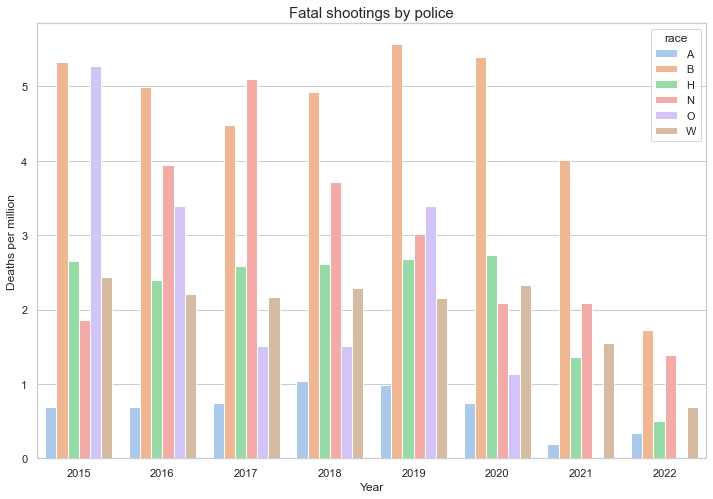

In [445]:
plt.figure(figsize=(12,8))
plt.title('Fatal shootings by police', fontsize=15)
sns.barplot(x='year', y='deaths_per_mil', hue='race', data=by_race)
plt.xlabel('Year')
plt.ylabel('Deaths per million')
plt.show()

In [446]:
df.race.unique()

array(['Asian', 'Hispanic', 'White', 'Native', 'Other', 'Black', 'None'],
      dtype=object)

In [447]:
# these numbers are skewed by the 'None' category for race 1,410 shootings total -- 18.52%

In [448]:
fig = px.histogram(by_race, x='year', y='deaths_per_mil', color='race', title='Percent of Fatal Shootings by Race (Excluding None)',
                  barnorm='percent', text_auto='.1f', category_orders={'race':['W', 'B', 'H', 'A', 'N', 'O']})
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide', xaxis_title='Year',
                  yaxis={"ticksuffix":"%"}, yaxis_title='Percent of Total Fatal Shootings', legend_title='Race')
fig.show()

In [449]:
# less Other in 2021 and 2022 and greater proportion of Hispanic and Black 

# what is this breakdown specifically for women?

In [450]:
# 343 fatal police shootings were of women
fem = df[df['gender'] == 'F']
# race breakdown
# account for population race proportions
race = {'White':'W','Black':'B', 'Hispanic':'H', 'Asian':'A', 'Native':'N','Other':'O', 'None':'No'}
fem_by_race = fem[['race','year','armed_3']].groupby(['race','year']).count().reset_index()
fem_by_race['race'] = fem_by_race['race'].map(race)
fem_by_race.rename(columns={'armed_3':'number_of_deaths'}, inplace=True)
#fem_by_race.head(20)

In [451]:
#fem_by_race = pd.merge(fem_by_race, pop, on='race')
#fem_by_race['deaths_per_mil'] = fem_by_race['number_of_deaths'] / (fem_by_race['2020_population']/2) 
# /2 b/c half pop is theoretically female

In [452]:
# female focus df
fem_df = coord_df.copy()

In [455]:
fem_by_race = fem_by_race.sort_values(by='year')

In [456]:
fem['race'].value_counts()/len(fem)

White       0.532578
Black       0.164306
None        0.164306
Hispanic    0.096317
Asian       0.019830
Native      0.014164
Other       0.008499
Name: race, dtype: float64

In [457]:
#df['race'].value_counts()
# (331.5*[0.593, 0.136, 0.189, 0.061, 0.013, 0.008]) == 196 W, 45 B, 63 H, 20 A, 4.3 N, 3 O 
#df[df['race']]
# if use this information, can make graphic simialr to last one on WaPo page

In [458]:
fig = px.bar(fem_by_race, x=fem_by_race.year, y='number_of_deaths', color='race', title='Fatal Shootings of Women by Race',
                  category_orders={'race':['W', 'B', 'H', 'A', 'N', 'O', 'No']}, text_auto='.1f')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide',
                  xaxis_title='Year', yaxis_title='Total Fatal Shootings of Women', legend_title='Race')
fig.show()

In [459]:
# an interesting pattern here

In [460]:
unarmed = df[df['armed_4'] == 'unarmed']
# 705 total unarmed
unarmed_by_race = unarmed['race'].value_counts()
unarmed_race_prop = unarmed_by_race/len(unarmed)

gun = df[df['armed_4'] == 'gun']
# 4414 total armed with gun
gun_by_race = gun['race'].value_counts()
gun_race_prop = gun_by_race/len(gun)

In [461]:
data['armed'].unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', nan, 'shovel',
       'vehicle', 'hammer', 'hatchet', 'sword', 'machete', 'box cutter',
       'undetermined', 'metal object', 'screwdriver', 'lawn mower blade',
       'flagpole', 'guns and explosives', 'cordless drill', 'crossbow',
       'BB gun', 'metal pole', 'Taser', 'metal pipe', 'metal hand tool',
       'blunt object', 'metal stick', 'sharp object', 'meat cleaver',
       'carjack', 'chain', "contractor's level", 'railroad spikes',
       'stapler', 'beer bottle', 'unknown weapon', 'binoculars',
       'pellet gun', 'bean-bag gun', 'baseball bat and fireplace poker',
       'straight edge razor', 'gun and knife', 'ax', 'brick',
       'baseball bat', 'hand torch', 'chain saw', 'garden tool',
       'pair of scissors', 'pole', 'pick-axe', 'flashlight', 'baton',
       'spear', 'chair', 'pitchfork', 'hatchet and gun', 'rock',
       'piece of wood', 'pipe', 'glass shard', 'motorcycle',
       'pepper spray', 'metal rake

In [463]:
unarmed_race_prop

White       0.437058
Black       0.270156
Hispanic    0.171146
None        0.084866
Asian       0.016973
Native      0.012730
Other       0.007072
Name: race, dtype: float64

In [464]:
gun_race_prop

White       0.415991
Black       0.230230
None        0.198686
Hispanic    0.129901
Native      0.010515
Asian       0.010296
Other       0.004381
Name: race, dtype: float64

In [465]:
no_none = df.copy()
no_none = no_none[no_none['race'] != 'None']

In [466]:
no_none['race'].value_counts()/len(no_none)
# percentages change when None race is removed

White       0.508958
Black       0.269383
Hispanic    0.180434
Asian       0.017917
Native      0.016014
Other       0.007293
Name: race, dtype: float64

In [467]:
no_none_unarmed = no_none[no_none['armed_4'] == 'unarmed']
no_none_unarmed_by_race = no_none_unarmed['race'].value_counts()
no_none_unarmed_race_prop = no_none_unarmed_by_race/len(no_none_unarmed)

no_none_gun = no_none[no_none['armed_4'] == 'gun']
no_none_gun_by_race = no_none_gun['race'].value_counts()
no_none_gun_race_prop = no_none_gun_by_race/len(no_none_gun)

In [468]:
no_none_unarmed_race_prop

White       0.477589
Black       0.295209
Hispanic    0.187017
Asian       0.018547
Native      0.013910
Other       0.007728
Name: race, dtype: float64

In [469]:
no_none_gun_race_prop

White       0.519136
Black       0.287315
Hispanic    0.162110
Native      0.013122
Asian       0.012849
Other       0.005467
Name: race, dtype: float64

85% of deadly police shootings did not have body cam footage

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


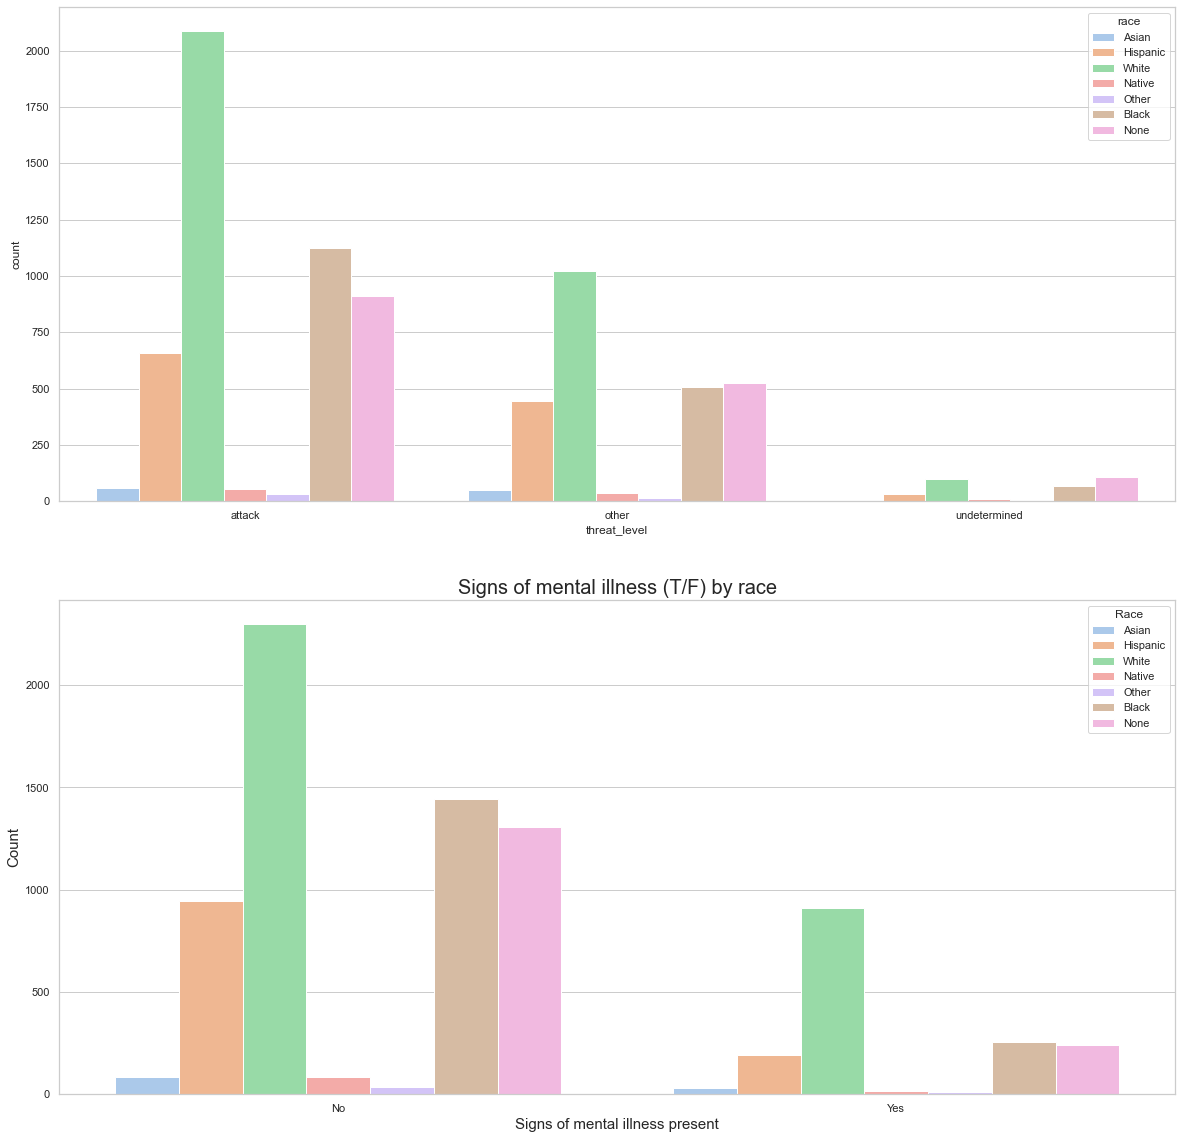

In [470]:
fig, ax = plt.subplots(2,1,figsize = (20,20))
#plt.rcParams['font.size'] = '25'

sns.countplot(x='threat_level', hue='race', data=df, ax=ax[0])
plt.title('Threat level by race', fontsize=20)
plt.xlabel('Threat level', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(title='Race')

sns.countplot(x='signs_of_mental_illness', hue='race', data=df, ax=ax[1])
plt.title('Signs of mental illness (T/F) by race', fontsize=20)
plt.xlabel('Signs of mental illness present', fontsize=15)
plt.xticks(ticks=[1,0],labels=['Yes', 'No'])
plt.ylabel('Count',fontsize=15)
plt.legend(title='Race')

#plt.tight_layout()
plt.show()

In [471]:
# adjust all of these for per 100,000 population ^^

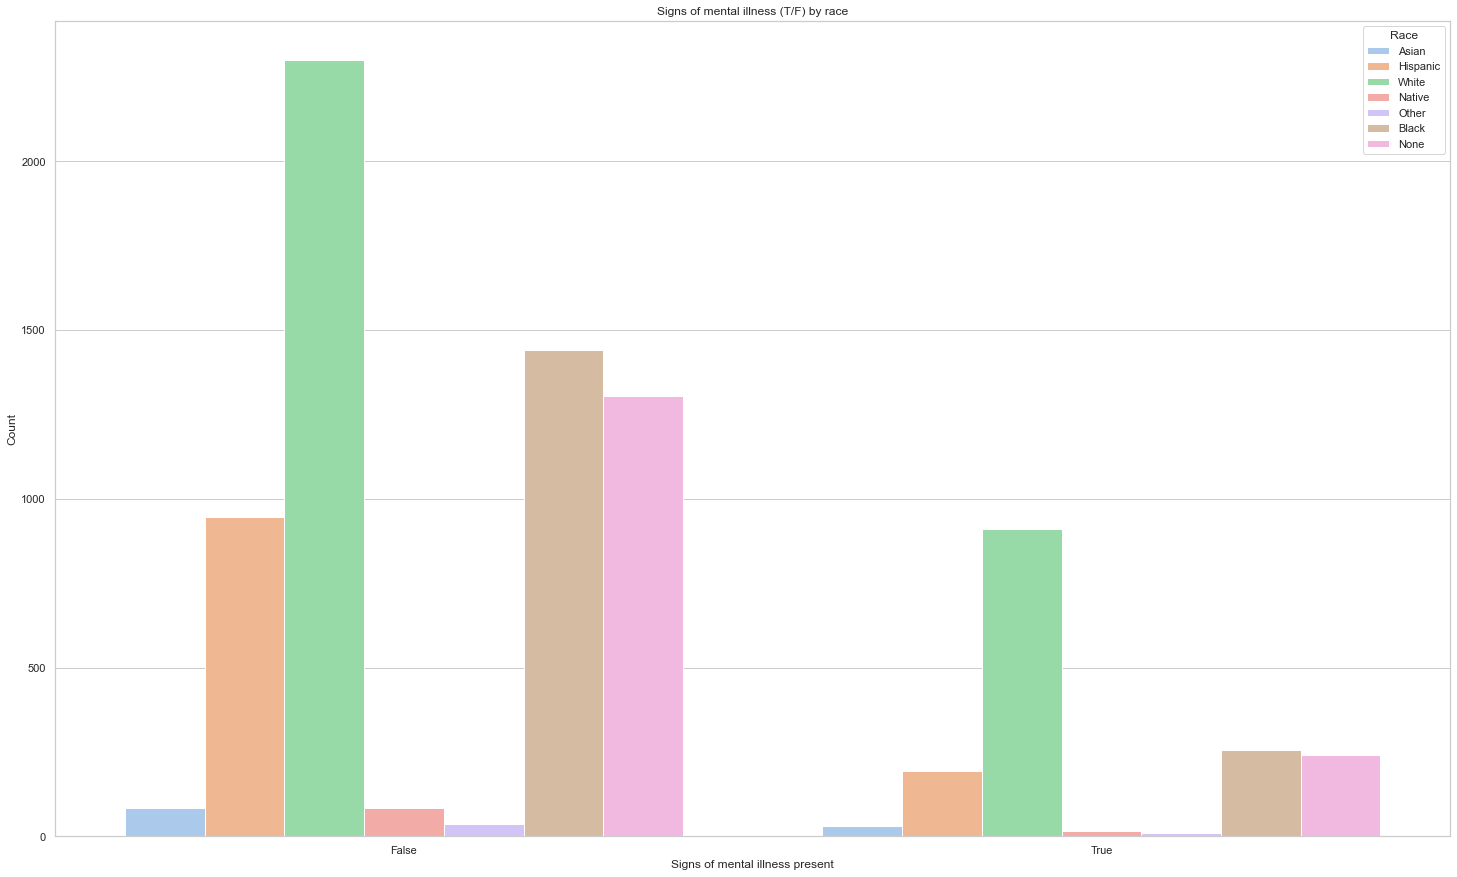

In [472]:
fig, ax = plt.subplots(figsize = (25,15))
plt.rcParams['font.size'] = '25'

sns.countplot(x='signs_of_mental_illness', hue='race', data=df)
plt.title('Signs of mental illness (T/F) by race')
plt.xlabel('Signs of mental illness present')
plt.ylabel('Count')
plt.legend(title='Race')
plt.show()

a significant number of shootings do not have race reported

In [473]:
# can use plotly cloropleth map for USA


In [474]:
# plot Race = 'None' by location
race_none = df[df['race'] == 'None']

In [475]:
df['city'].value_counts()

Los Angeles    130
Phoenix        103
Houston         88
San Antonio     68
Las Vegas       66
              ... 
Malta            1
Three Forks      1
Lodge Grass      1
Bozeman          1
Woonsocket       1
Name: city, Length: 3183, dtype: int64

In [476]:
df['city/state'].value_counts()

Los Angeles, CA    130
Phoenix, AZ        102
Houston, TX         87
San Antonio, TX     68
Las Vegas, NV       65
                  ... 
Dover, AR            1
Desha, AR            1
Bull Shoals, AR      1
Sheridan, AR         1
Woonsocket, RI       1
Name: city/state, Length: 3676, dtype: int64

In [477]:
# difficult to separate city and state while making sure that citites with the same name don't add together

In [478]:
# compare proportion of shootings per state to country overall and plot

In [479]:
df.columns

Index(['date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city',
       'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'is_geocoding_exact', 'age_binned_11_18',
       'age_binned_11_15', 'age_binned_7', 'age_binned_to_60',
       'age_binned_7_diff', 'armed_3', 'armed_4_toy', 'armed_4', 'armed_5_toy',
       'armed_7', 'count', 'month', 'year', 'quarter', 'state_name',
       'PopEstimate2015', 'PopEstimate2016', 'PopEstimate2017',
       'PopEstimate2018', 'PopEstimate2019', 'PopEstimate2020',
       'PopEstimate2021', 'city/state'],
      dtype='object')

In [480]:
coord_df.columns

Index(['date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city',
       'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'age_binned_11_18', 'age_binned_11_15', 'age_binned_7',
       'age_binned_to_60', 'age_binned_7_diff', 'armed_3', 'armed_4_toy',
       'armed_4', 'armed_5_toy', 'armed_7', 'count', 'month', 'year',
       'quarter', 'state_name', 'PopEstimate2015', 'PopEstimate2016',
       'PopEstimate2017', 'PopEstimate2018', 'PopEstimate2019',
       'PopEstimate2020', 'PopEstimate2021', 'city/state'],
      dtype='object')

In [481]:
coord_df['manner_of_death'].value_counts()

shot                7514
tasered and shot     339
Name: manner_of_death, dtype: int64

In [483]:
tableau_df = coord_df.drop(columns=['month','year','quarter','is_geocoding_exact', 'count','PopEstimate2015','PopEstimate2016','PopEstimate2017','PopEstimate2018','PopEstimate2019'])

In [484]:
fem_tableau_df = coord_df.drop(columns=['month','year','quarter','is_geocoding_exact', 'count','PopEstimate2015','PopEstimate2016','PopEstimate2017','PopEstimate2018','PopEstimate2019'])

In [485]:
tableau_df.columns

Index(['date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city',
       'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'longitude', 'latitude', 'age_binned_11_18',
       'age_binned_11_15', 'age_binned_7', 'age_binned_to_60',
       'age_binned_7_diff', 'armed_3', 'armed_4_toy', 'armed_4', 'armed_5_toy',
       'armed_7', 'state_name', 'PopEstimate2020', 'PopEstimate2021',
       'city/state'],
      dtype='object')

In [486]:
#missing_long_city.to_csv(f'missing_long_cities.csv')

In [487]:
# export important dataframes as csv
# export important dataframes as csv
#dataframe = (by_race, perc_race, shot_by_state, adj_shot_by_state, shot_by_city, shot_by_race, d, cams_by_city, top20_cams,
 #top20_cams_by_year, fem_by_race, unarmed_by_race, gun_by_race, no_none)
#names = ('by_race', 'perc_race', 'shot_by_state', 'adj_shot_by_state', 'shot_by_city', 'shot_by_race', 'd', 'cams_by_city', 'top20_cams',
 #'top20_cams_by_year', 'fem_by_race', 'unarmed_by_race', 'gun_by_race', 'no_none')


#x = zip(names, dataframe)
#for (name, data) in x: 
    #df = data
    #name = name
    #path = f'{name}.csv'
    #df.to_csv(path)
    
#df.to_csv(f'df.csv')
#coord_df.to_csv(f'coord_df_.csv')
#by_race.to_csv(f'race_pop.csv')

In [488]:
tableau_df.to_csv(f'nov_tableau_df.csv')
fem_tableau_df.to_csv(f'nov_fem_tableau_df.csv')